In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

In [45]:
#_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
#path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = sys.path[0] + '/data/'

print(PATH)

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


/home/onizuka-host/Zoho WorkDrive (Catalano Consulenze Tecniche)/My Folders/Documenti personali_/Corsi/Scuola di Python con Jensen/Esercizi/jensen/Tillämpad AI, datautvinning, maskininlärning och deep learning/DL/Project/data/
Found 1448 files belonging to 2 classes.


In [46]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 700 files belonging to 2 classes.


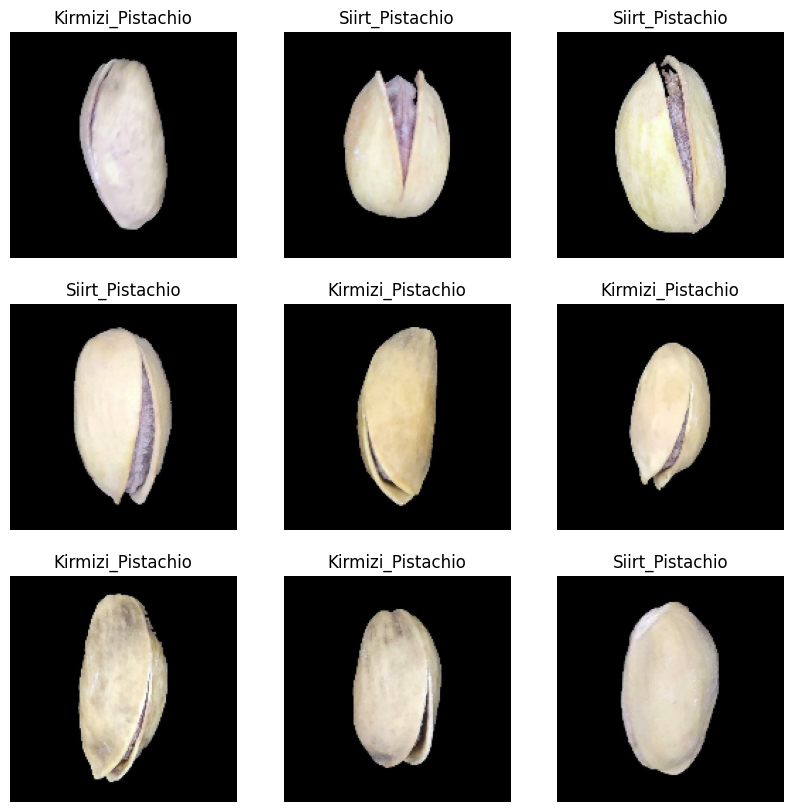

In [47]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [48]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [49]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 18
Number of test batches: 4


In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [51]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


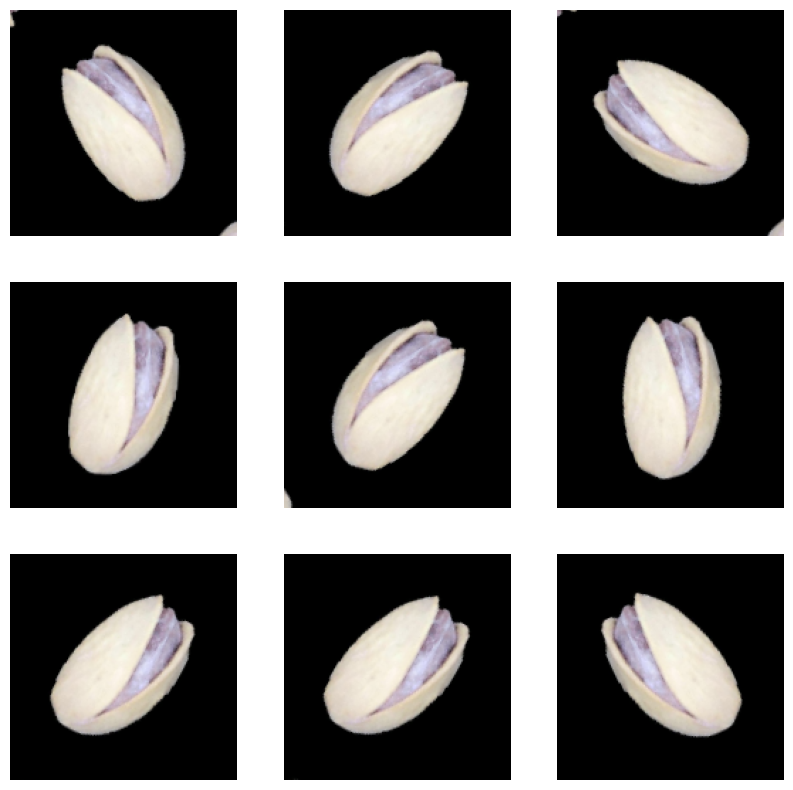

In [52]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [53]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [54]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [55]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [56]:
base_model.trainable = False


In [57]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [58]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [59]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [60]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [61]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [62]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [63]:
len(model.trainable_variables)


2

In [64]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


18/18 [==============================] - 11s 492ms/step - loss: 0.6677 - accuracy: 0.5892


In [65]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.67
initial accuracy: 0.59


In [66]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10


46/46 [==============================] - 43s 822ms/step - loss: 0.6393 - accuracy: 0.6140 - val_loss: 0.6162 - val_accuracy: 0.6136
Epoch 2/10
46/46 [==============================] - 40s 865ms/step - loss: 0.6084 - accuracy: 0.6367 - val_loss: 0.5738 - val_accuracy: 0.6399
Epoch 3/10
46/46 [==============================] - 43s 940ms/step - loss: 0.5592 - accuracy: 0.6754 - val_loss: 0.5441 - val_accuracy: 0.6416
Epoch 4/10
46/46 [==============================] - 40s 856ms/step - loss: 0.5175 - accuracy: 0.7058 - val_loss: 0.5121 - val_accuracy: 0.6923
Epoch 5/10
46/46 [==============================] - 39s 842ms/step - loss: 0.4878 - accuracy: 0.7327 - val_loss: 0.4817 - val_accuracy: 0.7080
Epoch 6/10
46/46 [==============================] - 40s 867ms/step - loss: 0.4598 - accuracy: 0.7472 - val_loss: 0.4663 - val_accuracy: 0.7220
Epoch 7/10
46/46 [==============================] - 42s 910ms/step - loss: 0.4524 - accuracy: 0.7624 - val_loss: 0.4530 - val_accuracy: 0.7273
Epoch 8/10

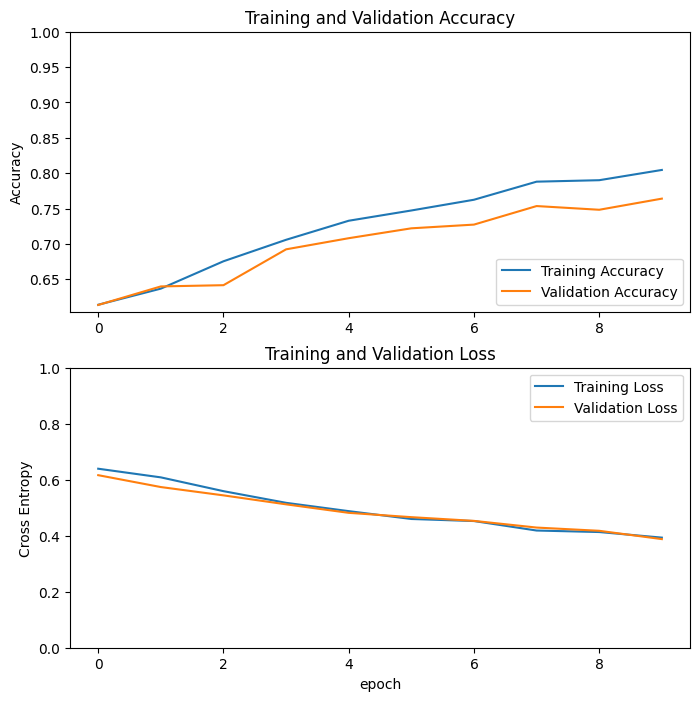

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [68]:
base_model.trainable = True


In [69]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [70]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [71]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [72]:
len(model.trainable_variables)


56

In [73]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20


46/46 [==============================] - 65s 1s/step - loss: 0.3025 - accuracy: 0.8598 - val_loss: 0.1886 - val_accuracy: 0.9283
Epoch 11/20
46/46 [==============================] - 58s 1s/step - loss: 0.2386 - accuracy: 0.9012 - val_loss: 0.1639 - val_accuracy: 0.9266
Epoch 12/20
46/46 [==============================] - 67s 1s/step - loss: 0.1848 - accuracy: 0.9192 - val_loss: 0.1401 - val_accuracy: 0.9353
Epoch 13/20
46/46 [==============================] - 62s 1s/step - loss: 0.1595 - accuracy: 0.9261 - val_loss: 0.2132 - val_accuracy: 0.8969
Epoch 14/20
46/46 [==============================] - 46s 990ms/step - loss: 0.1256 - accuracy: 0.9503 - val_loss: 0.1535 - val_accuracy: 0.9196
Epoch 15/20
46/46 [==============================] - 44s 949ms/step - loss: 0.1393 - accuracy: 0.9420 - val_loss: 0.1639 - val_accuracy: 0.9248
Epoch 16/20
46/46 [==============================] - 43s 945ms/step - loss: 0.1245 - accuracy: 0.9530 - val_loss: 0.0846 - val_accuracy: 0.9773
Epoch 17/20
46/4

In [74]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


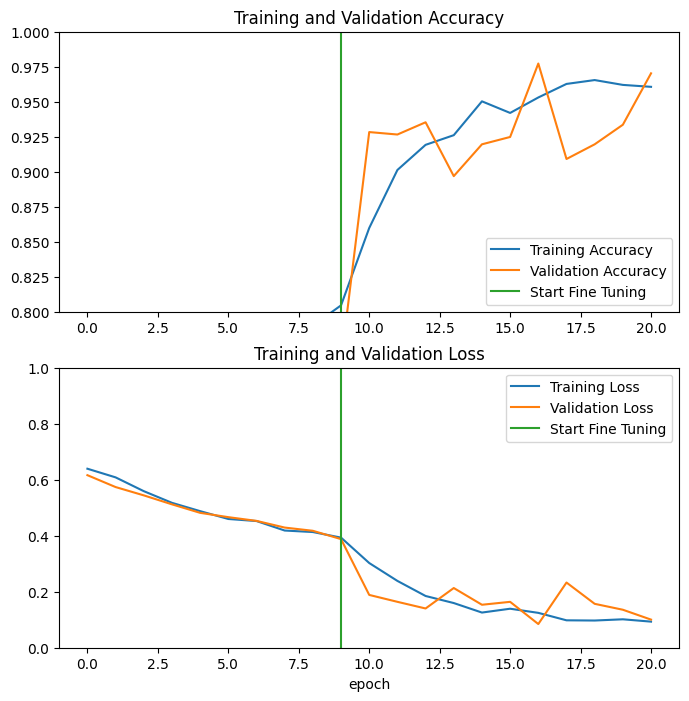

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [76]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


4/4 [==============================] - 2s 402ms/step - loss: 0.0789 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0]
Labels:
 [0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0]


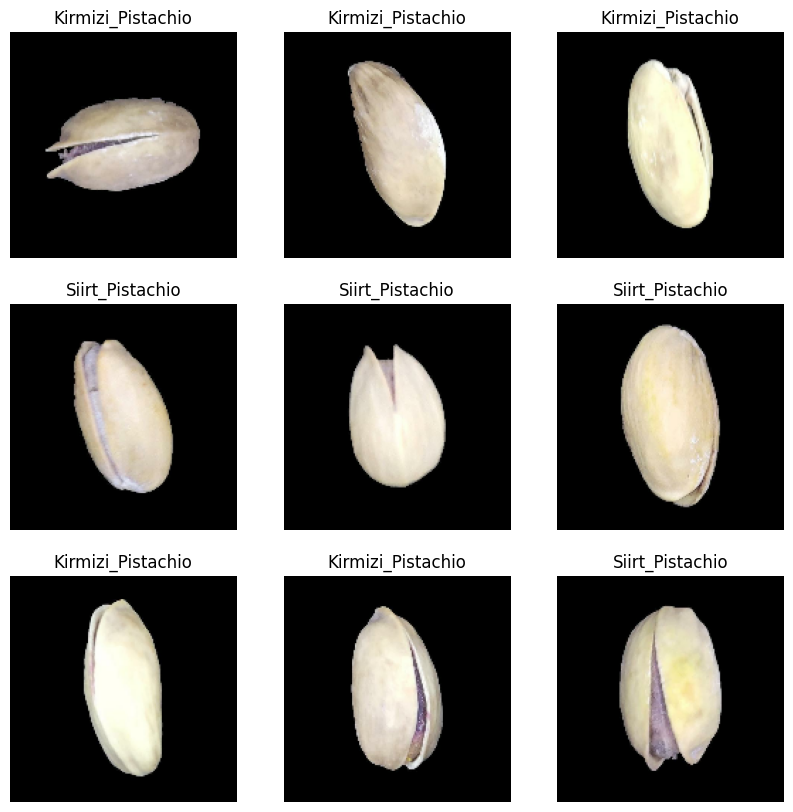

In [79]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
